In [1]:
import random
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from numba import njit, prange
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
from WoLF_lib import *

# Single run of WoLF-PHC

In [2]:
price_grid = np.linspace(0,1,7)
k = len(price_grid)
q = np.zeros((k,k))
p_table = np.zeros((2, 10))
p_table[0,0] = np.random.choice(price_grid)
p_table[1,0] = np.random.choice(price_grid)
for t in range(1,10):
    if t%2 == 0:
        p_table[0,t] = p_table[0,t-1]
        p_table[1,t] =  np.random.choice(price_grid)
    else:
        p_table[1,t] = p_table[1,t-1]
        p_table[0,t] =  np.random.choice(price_grid)

print(p_table)


[[0.66666667 0.83333333 0.83333333 0.83333333 0.83333333 0.83333333
  0.83333333 0.83333333 0.83333333 0.83333333]
 [0.66666667 0.66666667 0.5        0.5        0.66666667 0.66666667
  0.16666667 0.16666667 0.33333333 0.33333333]]


In [3]:
res=q_func_wolf(q, 0.3, 0.95, p_table, price_grid, 0, 1, 9)
print(res)

[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]


In [4]:
a,b,c,d,e=WoLF_PHC(0.3, 0.2, 0.6, 0.95, np.linspace(0,1,7), 500000)

In [5]:
c[:, 0:20]

array([[0.33333333, 0.66666667, 0.33333333, 0.33333333, 0.16666667,
        0.16666667, 0.66666667, 0.66666667, 0.        , 0.        ,
        0.33333333, 0.33333333, 0.83333333, 0.83333333, 0.5       ,
        0.5       , 0.33333333, 0.33333333, 1.        , 1.        ],
       [1.        , 0.        , 0.        , 0.5       , 0.5       ,
        0.16666667, 0.16666667, 0.83333333, 0.83333333, 0.5       ,
        0.5       , 0.5       , 0.5       , 0.16666667, 0.16666667,
        0.66666667, 0.66666667, 0.        , 0.        , 0.83333333]])

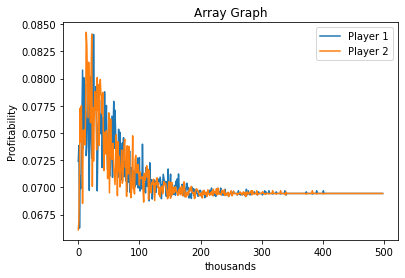

In [6]:
x_values = range(len(b))

# Plot the array as a line graph
plt.plot(x_values, a)
plt.plot(x_values, b)

# Add labels and title
plt.xlabel('thousands')
plt.ylabel('Profitability')
plt.title('Array Graph')
plt.legend(['Player 1', 'Player 2'])

# Display the graph
plt.show()

In [7]:
k=7
price_grid = np.linspace(0,1,k)
policy, N, avg_policy, q= update_policy_WoLF((np.ones((k, k)) / k), price_grid, 0.6, 0.2, p_table, q, t, np.zeros(k), 1, (np.ones((k, k)) / k), k)
   

/Users/mikkelEngelsted/Documents/Datalogi-økonomi/Bachelorprojekt/Code/WoLF_lib.py:123: RuntimeWarning: divide by zero encountered in double_scalars
  avg_policy[current_state_idx, :] = avg_policy[current_state_idx, :] + (1 / N[current_state_idx]) * (policy[current_state_idx, :] - avg_policy[current_state_idx, :])
/Users/mikkelEngelsted/Documents/Datalogi-økonomi/Bachelorprojekt/Code/WoLF_lib.py:123: RuntimeWarning: invalid value encountered in multiply
  avg_policy[current_state_idx, :] = avg_policy[current_state_idx, :] + (1 / N[current_state_idx]) * (policy[current_state_idx, :] - avg_policy[current_state_idx, :])


In [8]:
policy

array([[0.14285714, 0.14285714, 0.14285714, 0.14285714, 0.14285714,
        0.14285714, 0.14285714],
       [0.74285714, 0.04285714, 0.04285714, 0.04285714, 0.04285714,
        0.04285714, 0.04285714],
       [0.14285714, 0.14285714, 0.14285714, 0.14285714, 0.14285714,
        0.14285714, 0.14285714],
       [0.14285714, 0.14285714, 0.14285714, 0.14285714, 0.14285714,
        0.14285714, 0.14285714],
       [0.14285714, 0.14285714, 0.14285714, 0.14285714, 0.14285714,
        0.14285714, 0.14285714],
       [0.14285714, 0.14285714, 0.14285714, 0.14285714, 0.14285714,
        0.14285714, 0.14285714],
       [0.14285714, 0.14285714, 0.14285714, 0.14285714, 0.14285714,
        0.14285714, 0.14285714]])

In [9]:
print(d)

[[0.         1.         0.         0.         0.         0.
  0.        ]
 [0.         1.         0.         0.         0.         0.
  0.        ]
 [0.         1.         0.         0.         0.         0.
  0.        ]
 [0.         0.         1.         0.         0.         0.
  0.        ]
 [0.         0.         0.         1.         0.         0.
  0.        ]
 [0.         0.         0.46957053 0.23592546 0.29450402 0.
  0.        ]
 [0.         0.         0.         1.         0.         0.
  0.        ]]
